In [1]:
from commonfunctions import *
from scipy.signal import find_peaks, find_peaks_cwt
import math

# Show the matlpotlib figures inside the notebook
%matplotlib inline

In [2]:
def binraization(img,n=8,t=15):

    outputimg = np.zeros(img.shape)
    intimg = np.zeros(img.shape)
    h = img.shape[1]
    w = img.shape[0]
    s= min(w,h)//n
    count = s**2
    img = np.pad(img,s,"constant")
    intimg = np.cumsum(img ,axis =1)
    intimg = np.cumsum(intimg ,axis =0)
    a = np.roll(intimg,-s//2,axis =0)
    a = np.roll(a,-s//2,axis =1)
    a[:,-s//2:]=a[-s//2-1,-s//2-1]
    a[-s//2:,:]=a[-s//2-1,-s//2-1]
    b = np.roll(intimg,s//2+1,axis =0)
    b = np.roll(b,-s//2,axis =1)
    b[0:s//2+1,:]=0
    b[:,-s//2:]=0
    
    c = np.roll(intimg,s//2+1,axis =1)
    c = np.roll(c,-s//2,axis =0)
    c[:,0:s//2+1]=0
    c[-s//2:,:]=0
    
    d = np.roll(intimg,s//2+1,axis =0)
    d = np.roll(d,s//2+1,axis =1)
    d[0:s//2+1,:]=0
    d[:,0:s//2+1]=0

    sum = (a-b-c+d)*(100-t)/100
    outputimg = np.where(img>sum/count, 1, 0)
    return outputimg[s:-s,s:-s]

def segement_hand_written(img):
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    fimg = median(img)
    glares = (fimg > 195)
    bimg = binraization(fimg,window,7)
    output = (bimg ) - (glares)
    output = median(output)
    output = binary_dilation(1-output)
    vse = np.array([[0,1,0],
                    [0,1,0],
                    [0,1,0]      ])

    hse = np.array([[0,0,0],
                    [1,1,1],
                    [0,0,0]
    ])
    output = binary_dilation(output , vse)
    output = binary_dilation(output , hse)
    output = 1 - output
    return output #the reuslt is binary image

def separateStaffs(img, thickness, distance):
    rows_sum = np.sum(1 - img, axis=1)
    lines,_  = find_peaks(rows_sum, height = img.shape[1] * 0.5, distance=distance+thickness//2)
    parts = [0]

    for i in range(len(lines) - 1):
        if lines[i + 1] - lines[i] > 1.5 * distance:
            parts.append((lines[i + 1] + lines[i]) // 2)

    parts.append(img.shape[0]-1)

    return parts

def get_candidates_lines(bimg, thickness):
    fimg = np.copy(bimg)
    candidates = [] # Contains list of candidate staffs lines (row, begin, height)
    cols = fimg.shape[1]
    rows = fimg.shape[0]
    delta = max(1 , thickness//3)
    t2 = thickness+ delta
    t1 = abs(thickness-delta)
    flag = False
    for i in range(cols):
        for j in range(rows):
            if fimg[j,i] == 0 and flag == False:
                beg = j
                flag = True
            elif fimg[j,i] == 1 and flag == True:
                flag = False
                if j-beg > t2 or j-beg < t1:
                    fimg[beg:j, i] = 1
                else:
                    candidates.append((i, beg, j-beg))
    return fimg, candidates

def filter_candidates_lines(bimg,v,thickness , distance):
    fimg = np.copy(bimg)
    candidates = np.copy(v) 
    cols = fimg.shape[1]
    rows = fimg.shape[0]
    for c in candidates:
        i, beg, t = c
        if np.any(fimg[beg-distance+thickness:beg-1, i] == 0):
            fimg[beg:beg+t, i] = 1
    return fimg, candidates

In [3]:
def getStaffs(image):
    h, w = image.shape
    window , width = get_dimensions(w,h)
    hist = histogram(image,nbins=256,source_range='dtype')
    hist_acc = np.cumsum(hist[0])
    tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
    segmented = []
    if tratio < 4:
        segmented = segement_hand_written(image)
    elif 75 > tratio > 4:
        segmented = binraization(image,window,35)
    else: 
        segmented = (image > 150).astype("uint8")

    thickness, distance = get_lengthes(segmented)
    fimg, candidates = get_candidates_lines(segmented, thickness)
    fimg, candidates = filter_candidates_lines(fimg,candidates,thickness,distance)

    parts = separateStaffs(fimg, thickness, distance)
    staffs = []
    for start, end in zip(parts[:-1],parts[1:]):
        staffs.append(image[start:end,:])
    return staffs

../inputs/test-set-scanned/test-cases


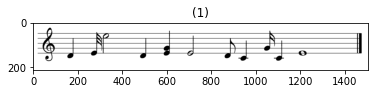

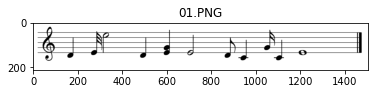

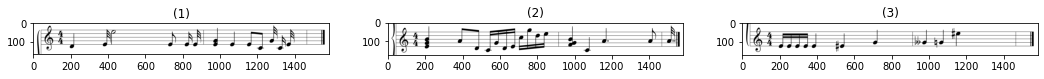

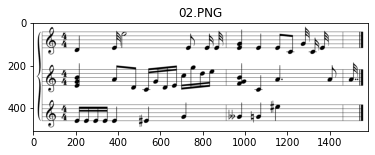

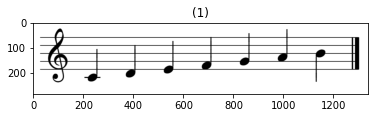

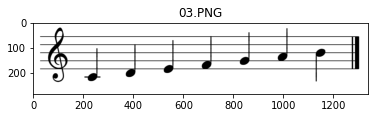

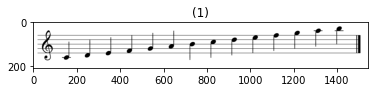

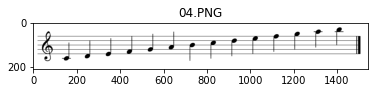

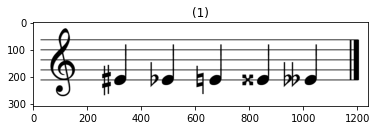

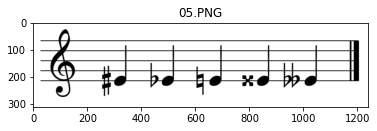

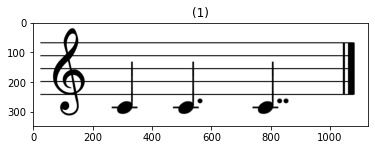

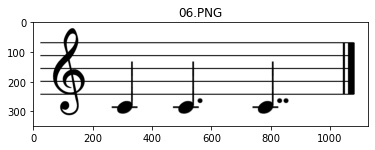

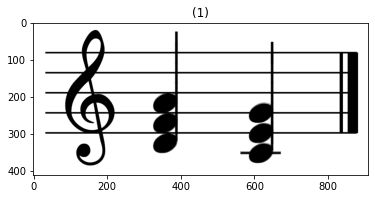

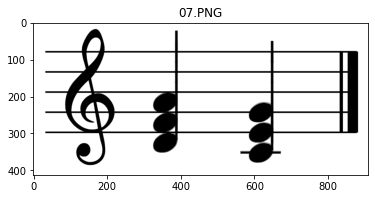

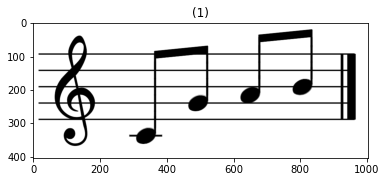

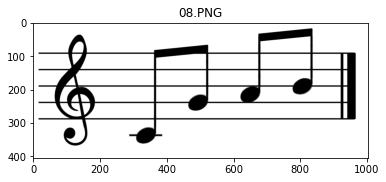

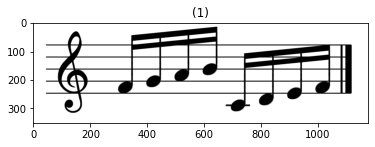

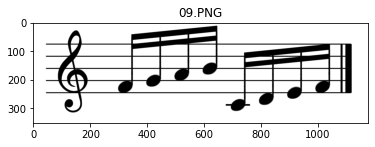

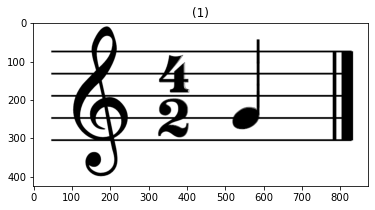

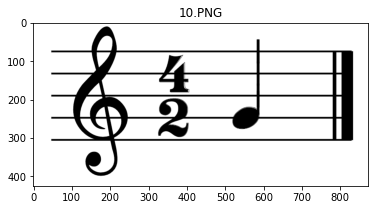

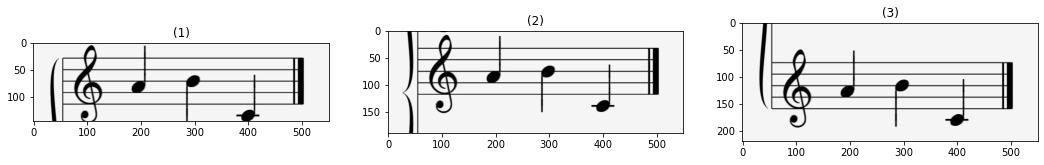

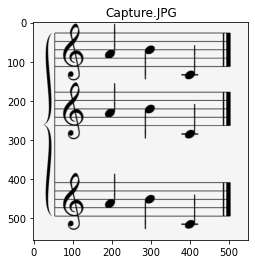

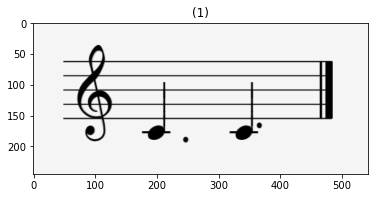

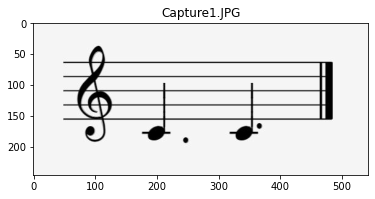

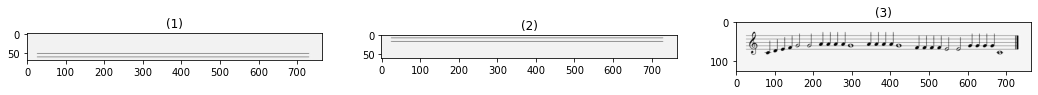

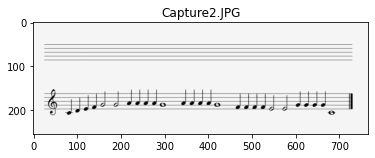

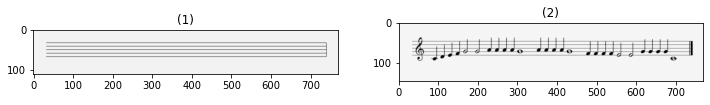

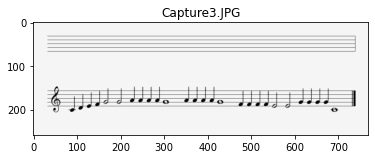

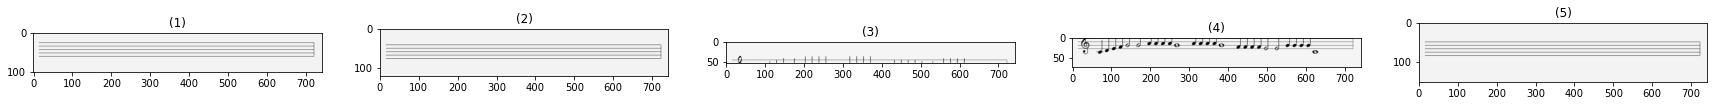

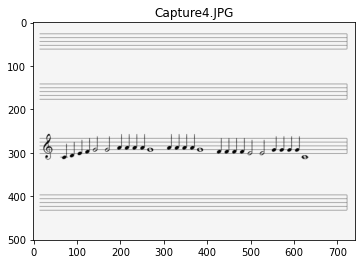

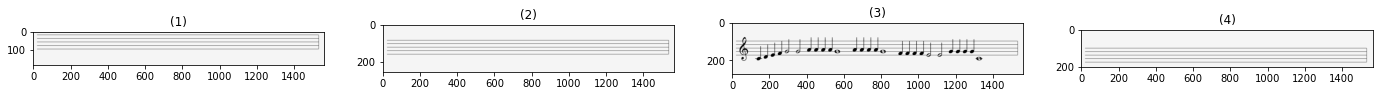

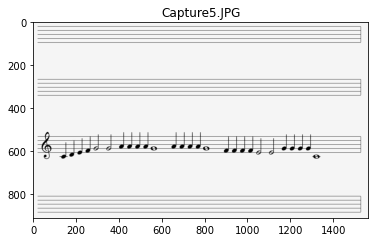

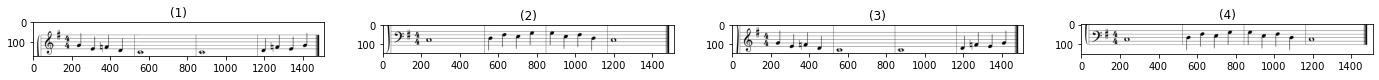

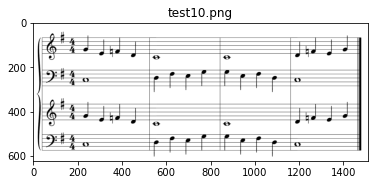

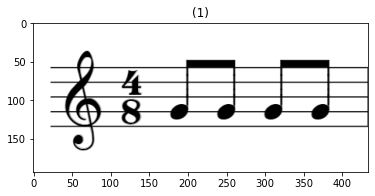

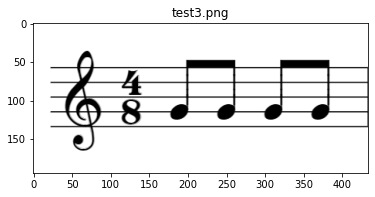

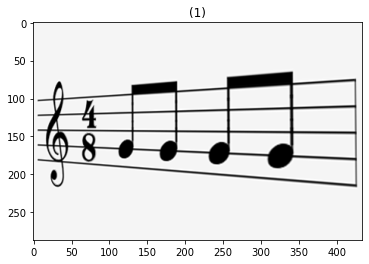

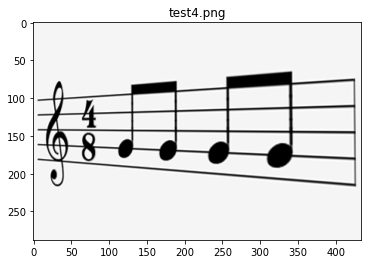

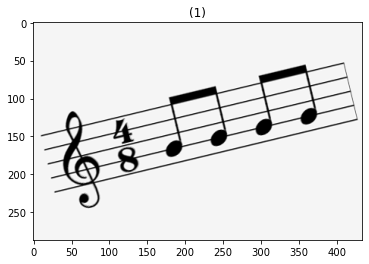

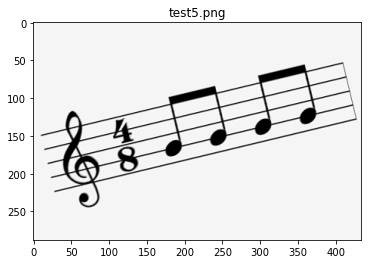

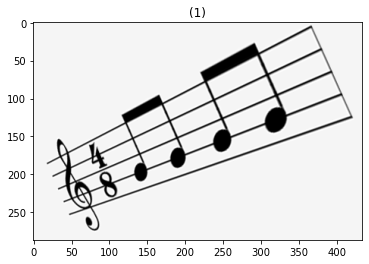

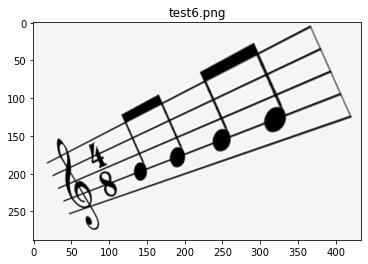

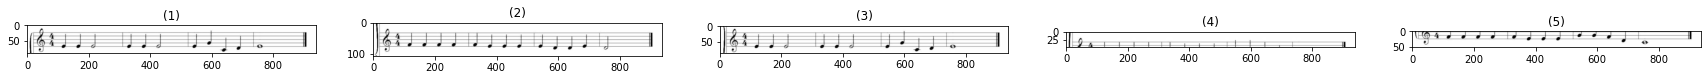

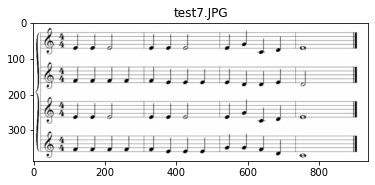

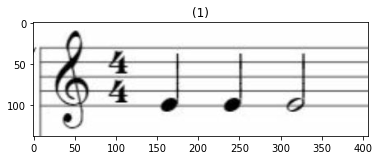

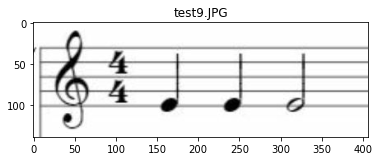

In [6]:
images, files = load_images_from_folder("../inputs/test-set-scanned/test-cases")
# images, files = load_images_from_folder("../inputs/test-set-camera-captured/test-cases")
outpath = "../outputs/"
for image, file in zip(images, files):
    staffs = getStaffs(image)
    show_images(staffs)
    show_images([image], [file])
    for i, staff in enumerate(staffs):
        tmp = file.split('.')
        tmp[0] += "_" + str(i)
        cv2.imwrite(outpath + '.'.join(tmp), staff)